O problema
Você foi contratado(a) para uma consultoria, e seu trabalho envolve
analisar os dados de preço do petróleo brent, que pode ser encontrado no site
do ipea. Essa base de dados histórica envolve duas colunas: data e preço (em
dólares).
Um grande cliente do segmento pediu para que a consultoria
desenvolvesse um dashboard interativo para gerar insights relevantes para
tomada de decisão. Além disso, solicitaram que fosse desenvolvido um modelo
de Machine Learning para fazer o forecasting do preço do petróleo.

Todas as bibliotecas necessárias para a resolução do problema já listadas para o carregamento. Todos os requisitos estão listados no arquivo requirements.txt.


import pandas as pd
import requests
import os
import sys
import datetime



from bs4 import BeautifulSoup
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from scipy.signal import find_peaks
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error


import pandas as pd
import requests
import os
import sys
import datetime
from bs4 import BeautifulSoup
import yfinance as yf
import numpy as np
import seaborn as sns
from scipy.signal import find_peaks
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go


%pip install etl
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go

scripts_dir = os.path.join(os.getcwd(), 'scripts')
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)


import pandas as pd
import requests
import datetime
from bs4 import BeautifulSoup
import yfinance as yf
import numpy as np
import seaborn as sns
from scipy.signal import find_peaks
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [282]:
import pandas as pd
import requests
import os
import sys
import datetime
from bs4 import BeautifulSoup
import yfinance as yf
import numpy as np
import seaborn as sns
from scipy.signal import find_peaks
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

scripts_dir = os.path.join(os.getcwd(), 'scripts')
if scripts_dir not in sys.path:
    sys.path.insert(0, scripts_dir)


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go


In [283]:
os.chdir('/home/naina/challenge04')

# Adiciona o caminho correto para a pasta scripts
scripts_dir = os.path.abspath(os.path.join(os.getcwd(), 'scripts'))
if scripts_dir not in sys.path:
    sys.path.insert(0, scripts_dir)

import extract

## DADOS DO BRENT

In [284]:
extract.extract_ipeadata()

In [285]:
df_brent = pd.read_csv('data/processed/data_brent_clean.csv', sep=',')
df_brent.head()

,date,brent_price
0,1987-01-06,18.65
1,1987-01-07,18.98
2,1987-01-09,18.43
3,1987-01-10,18.50
4,1987-01-12,17.65


Uma vez que a pipeline de extração já transforma os dados quase que por completo são feitos apenas alguns ajustes como a o agrupamento por ano para melhor visualização mas deixando um dataframe com valores diários para treinamento do modelo.

In [286]:
# Carregando os dados

df_brent = df_brent[df_brent["date"] >= "2000-01-01"]
df_brent.set_index("date", inplace=True)
df_brent_copy = df_brent.copy()
df_brent_y = df_brent.copy()
df_brent_y.index = pd.to_datetime(df_brent_y.index)
df_brent_y = df_brent_y.resample("YE").mean()


In [287]:
df_brent.head()

,brent_price
date,
2000-01-02,27.35
2000-01-03,29.78
2000-01-06,29.69
2000-01-08,25.24
2000-01-09,35.09


In [288]:
df_brent_y.head()

,brent_price
date,
2000-12-31,28.647172
2001-12-31,24.755098
2002-12-31,25.105191
2003-12-31,28.837113
2004-12-31,37.555664


Fazendo um plot dos dados anuais do brent para identificação de "picos e vales " do preço do barril de petróleo.

In [289]:
df_brent_y.index = pd.to_datetime(df_brent_y.index)
df_brent_y.to_csv('data/processed/data_brent_yearly.csv')

In [290]:
fig = px.line(df_brent_y, x=df_brent_y.index, y='brent_price', title='Preço Médio Anual do Brent',
              hover_data={'brent_price': ':.2f'}, hover_name=df_brent_y.index)

# Adicionar anotações para os picos e vales
annotations = [
    dict(x='2008-12-31', y=df_brent_y.loc['2008-12-31', 'brent_price'], xref='x', yref='y',
         text='Pico em 2008', showarrow=True, arrowhead=1, ax=0, ay=-40, font=dict(size=10)),
    dict(x='2009-12-31', y=df_brent_y.loc['2009-12-31', 'brent_price'], xref='x', yref='y',
         text='Vale em 2009', showarrow=True, arrowhead=1, ax=0, ay=40, font=dict(size=10)),
    dict(x='2011-12-31', y=df_brent_y.loc['2011-12-31', 'brent_price'], xref='x', yref='y',
         text='Pico em 2011', showarrow=True, arrowhead=1, ax=0, ay=-40, font=dict(size=10)),
    dict(x='2015-12-31', y=df_brent_y.loc['2015-12-31', 'brent_price'], xref='x', yref='y',
         text='Após alguns anos de estabilização há uma nova queda brusca em 2015', showarrow=True, arrowhead=1, ax=0, ay=-40, font=dict(size=10)),
    dict(x='2016-12-31', y=df_brent_y.loc['2016-12-31', 'brent_price'], xref='x', yref='y',
         text='Queda a valores mínimos em 2017', showarrow=True, arrowhead=1, ax=0, ay=-40, font=dict(size=10)),
    dict(x='2018-12-31', y=df_brent_y.loc['2018-12-31', 'brent_price'], xref='x', yref='y',
         text='Período de alguma recuperação até 2019', showarrow=True, arrowhead=1, ax=0, ay=-40, font=dict(size=10)),
    dict(x='2020-12-31', y=df_brent_y.loc['2020-12-31', 'brent_price'], xref='x', yref='y',
         text='Período de recuperação inicia em 2021', showarrow=True, arrowhead=1, ax=0, ay=-40, font=dict(size=10)),
    dict(x='2022-12-31', y=df_brent_y.loc['2022-12-31', 'brent_price'], xref='x', yref='y',
         text='Pico em 2023', showarrow=True, arrowhead=1, ax=0, ay=-40, font=dict(size=10)),
]

# Adicionar anotações ao gráfico
fig.update_layout(annotations=annotations)

# Personalizar layout e eixo X para exibir anos corretamente
fig.update_layout(
    title='Preço Médio Anual do Brent',
    xaxis_title='Ano',
    yaxis_title='Preço Médio (USD)',
    template='plotly_white',
    xaxis=dict(
        tickmode='linear',
        dtick="M12",
        tickformat="%Y"
    )
)

# Adicionar informações que aparecem ao passar o mouse
fig.update_traces(
    hovertemplate="<b>Ano:</b> %{x}<br><b>Preço:</b> %{y:.2f} USD<extra></extra>"
)

fig.show()

### Análise dos picos e vales do preço do barril de petróleo Brent:
* Pico em 2008: O preço do barril de petróleo Brent atingiu o seu pico histórico em 2008, ultrapassando os 90 USD.
  O preço do barril de petróleo Brent atingiu seu pico histórico em 2008, ultrapassando os 90 USD. Esse aumento foi impulsionado por uma demanda global crescente, especialmente de economias emergentes como China e Índia, que elevaram o consumo de petróleo a níveis sem precedentes. Além disso, a Organização dos Países Exportadores de Petróleo (OPEP) implementou cortes na produção, restringindo a oferta e contribuindo para a alta dos preços.

* Vale em 2009: Após o pico em 2008, o preço do barril de petróleo Brent caiu bruscamente em 2009, atingindo valores mínimos.
  Após o pico em 2008, o preço do barril de petróleo Brent caiu bruscamente em 2009, atingindo valores mínimos. Essa queda foi resultado da recessão global de 2008-2009, que reduziu significativamente a demanda por petróleo. A desaceleração econômica levou a uma diminuição no consumo de energia, pressionando os preços para baixo.
* Pico em 2011: Em 2011, o preço do barril de petróleo Brent voltou a subir, atingindo um novo pico.
  Em 2011, o preço do barril de petróleo Brent voltou a subir, atingindo um novo pico. Esse aumento foi influenciado por tensões geopolíticas no Oriente Médio e na África do Norte, que afetaram a oferta de petróleo. Além disso, a recuperação econômica de algumas economias desenvolvidas contribuiu para o aumento da demanda por energia, elevando os preços.
* Após alguns anos de estabilização, há uma nova queda brusca em 2015, seguida de uma recuperação em 2016.
  Após alguns anos de estabilização, houve uma nova queda brusca em 2015, seguida de uma recuperação em 2016. A queda foi causada por um excesso de oferta no mercado, com aumento na produção de petróleo de xisto nos Estados Unidos e a decisão da OPEP de não reduzir a produção. A recuperação em 2016 ocorreu devido a cortes na produção acordados pela OPEP e outros produtores, equilibrando a oferta e a demanda
* Queda a valores mínimos em 2017.
  Em 2017, o preço do petróleo Brent caiu para valores mínimos. Essa queda foi atribuída a um aumento na produção de petróleo de xisto nos Estados Unidos, que superou as expectativas de oferta, e a uma desaceleração na demanda global por energia.
* Recuperação em 2018.
  Em 2018, o preço do petróleo Brent experimentou uma recuperação, impulsionada por cortes na produção pela OPEP e outros produtores, bem como pela crescente demanda por energia. A recuperação foi sustentada por fatores geopolíticos, como as sanções dos Estados Unidos ao Irã e a crise na Venezuela, que afetaram a oferta de petróleo.
* Queda de 2019 a 2021
  De 2019 a 2021, o preço do petróleo Brent experimentou uma queda significativa. A pandemia de COVID-19 levou a uma redução drástica na demanda por petróleo devido a lockdowns e desaceleração econômica global. Além disso, a guerra comercial entre os Estados Unidos e a China criou incertezas nos mercados de energia, impactando negativamente os preços. 
* Período de recuperação inicia em 2021 e atinge um novo pico em 2023.
  A partir de 2021, o mercado de petróleo iniciou um período de recuperação, atingindo um novo pico em 2023. Essa recuperação foi impulsionada pela reabertura econômica pós-pandemia, aumento na demanda por energia e cortes na produção pela OPEP+. No entanto, a recuperação também enfrentou desafios, como a escassez de oferta e tensões geopolíticas que afetaram a estabilidade do mercado.
  
* Um novo periodo de estabilização?
  Após o pico em 2022, o mercado de petróleo pode estar entrando em um período de estabilização. Fatores como o aumento da produção de petróleo de xisto nos Estados Unidos, a transição para fontes de energia renováveis e políticas ambientais mais rigorosas podem influenciar a oferta e a demanda, levando a uma estabilização nos preços do petróleo Brent. 

## DADOS PRODUÇÃO DE PETRÓLEO - OPEC E NÃO OPEC

In [291]:
extract.extract_production_oil()

In [292]:
df_opec_production = pd.read_csv('data/processed/opec_total_production.csv', index_col='date', parse_dates=True)
df_opec_production.head()

,production_value_opec
date,
2000-01-01,25.252534
2000-01-02,25.252534
2000-01-03,25.252534
2000-01-04,25.252534
2000-01-05,25.252534


## Produção de petróleo dos países membros da OPEP - Milhões de barris por dia

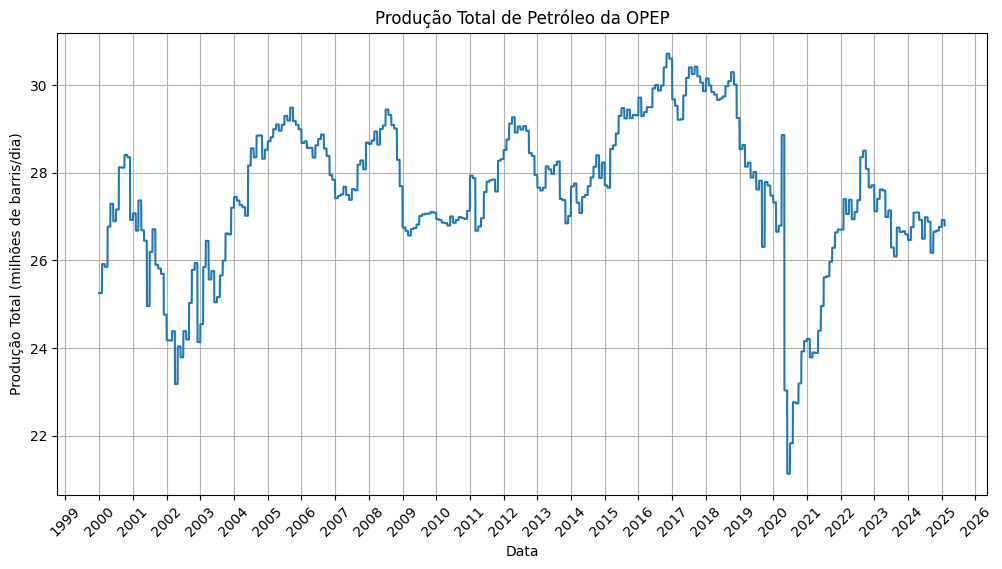

In [293]:
plt.figure(figsize=(12, 6))
plt.plot(df_opec_production.index, df_opec_production['production_value_opec'])
plt.title('Produção Total de Petróleo da OPEP')
plt.xlabel('Data')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.ylabel('Produção Total (milhões de barris/dia)')
plt.grid(True)
plt.show()


In [294]:
df_no_opec_production = pd.read_csv('data/processed/no_opec_total_production.csv', index_col='date', parse_dates=True)
df_no_opec_production.head()

,production_value_no_opec
date,
2000-01-01,39.880136
2000-01-02,39.880136
2000-01-03,39.880136
2000-01-04,39.880136
2000-01-05,39.880136


## Produção de petróleo dos países não membros da OPEP - Milhões de barris por dia

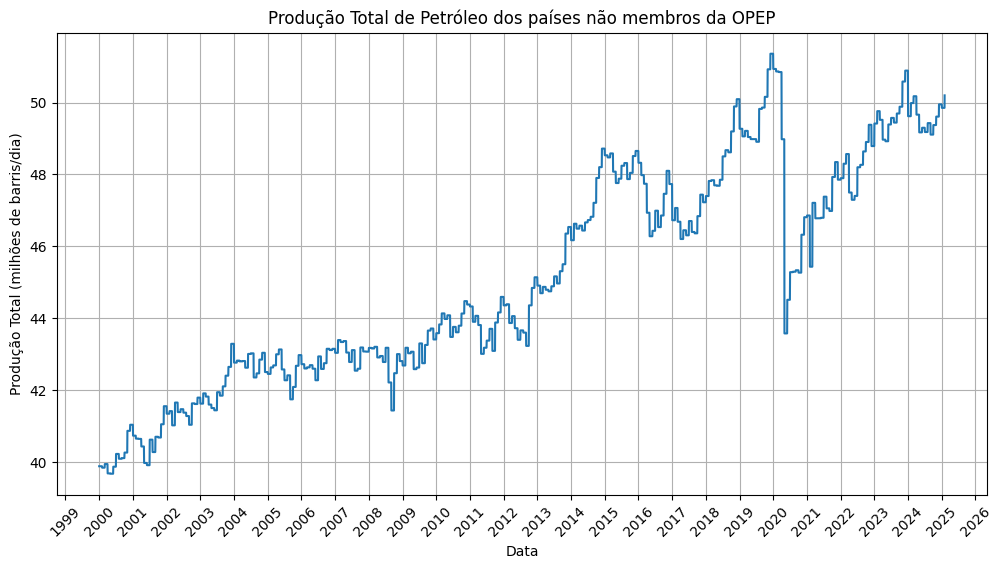

In [295]:
plt.figure(figsize=(12, 6))
plt.plot(df_no_opec_production.index, df_no_opec_production['production_value_no_opec'])
plt.title('Produção Total de Petróleo dos países não membros da OPEP')
plt.xlabel('Data')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.ylabel('Produção Total (milhões de barris/dia)')
plt.grid(True)
plt.show()


## Comparação entre a produção de petróleo da OPEP e dos países não membros da OPEP

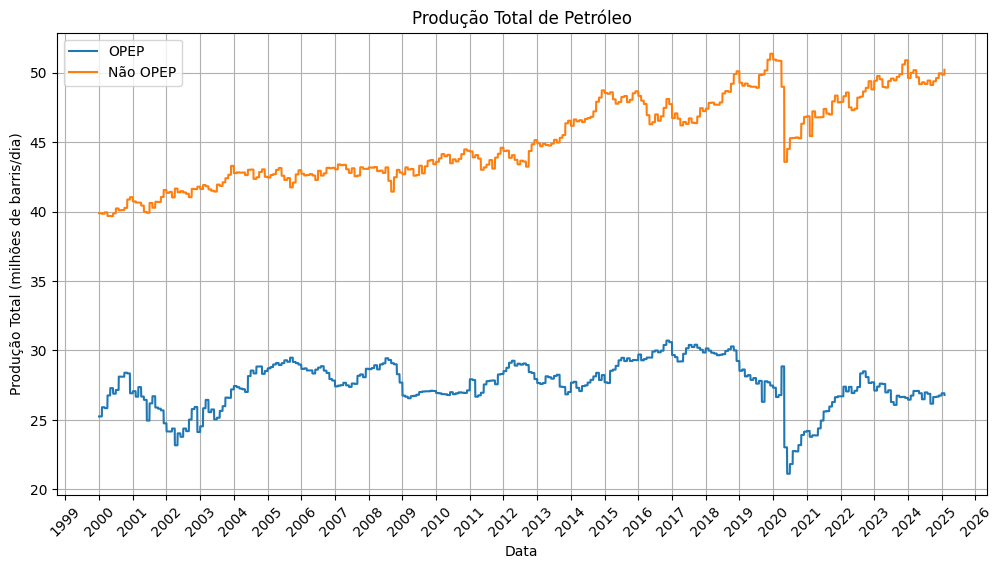

In [296]:
#opep e não opep
plt.figure(figsize=(12, 6))
plt.plot(df_opec_production.index, df_opec_production['production_value_opec'], label='OPEP')
plt.plot(df_no_opec_production.index, df_no_opec_production['production_value_no_opec'], label='Não OPEP')
plt.title('Produção Total de Petróleo')
plt.xlabel('Data')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.ylabel('Produção Total (milhões de barris/dia)')
plt.legend()
plt.grid(True)
plt.show()

## DADOS DXY - DÓLAR INDEX

In [297]:
extract.extract_dxy()

[*********************100%***********************]  1 of 1 completed


In [298]:
df_dxy = pd.read_csv('data/processed/dxy.csv', index_col='date', parse_dates=True)
df_dxy.head()

,dxy_value_close
date,
2000-01-03,100.220001
2000-01-04,100.410004
2000-01-05,100.379997
2000-01-06,100.650002
2000-01-07,100.800003


In [299]:
df_dxy_y = df_dxy.copy()

In [300]:
precos = df_brent_y['brent_price'].values
picos, _ = find_peaks(precos)
vales, _ = find_peaks(-precos)

### Avaliando os dados do DXY Anualmente para acompanhar a variação do preço do petróleo Brent e a produção de petróleo

In [301]:
#agrupo por ano para calcular a média sabendo  que a data é o index
df_dxy_y['date'] = pd.to_datetime(df_dxy_y.index)
df_dxy_y.set_index('date', inplace=True)
df_dxy_y = df_dxy_y.resample('YE').mean()


## Dolar Index - DXY - Análise Anual

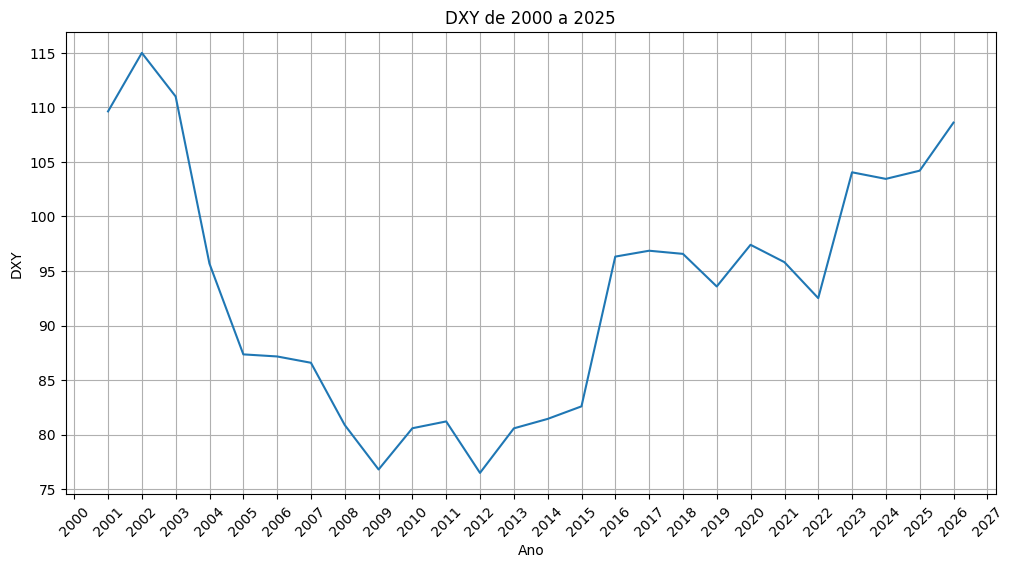

In [302]:
#plotando o grafico ano a ano do dolar
plt.figure(figsize=(12, 6))
plt.plot(df_dxy_y.index, df_dxy_y['dxy_value_close'])
plt.title('DXY de 2000 a 2025')
plt.xlabel('Ano')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().tick_params(axis='x', rotation=45)
plt.ylabel('DXY')
plt.grid(True)
plt.show()


## Comparação entre o preço do petróleo Brent e o DXY

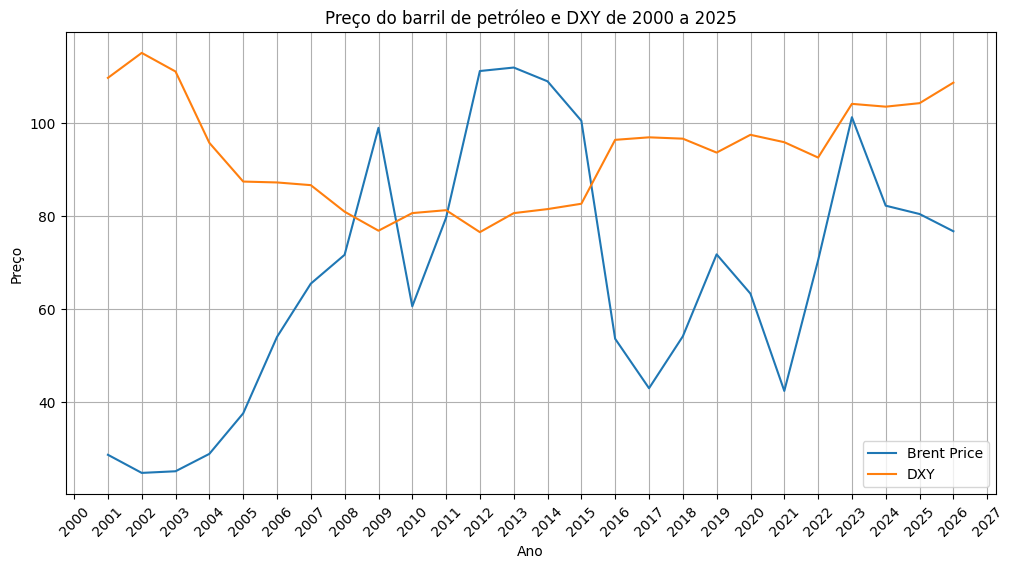

In [303]:
#plotando o grafico do preço do barril de petroleo e o dolar
plt.figure(figsize=(12, 6))
plt.plot(df_brent_y.index, df_brent_y['brent_price'], label='Brent Price')
plt.plot(df_dxy_y.index, df_dxy_y['dxy_value_close'], label='DXY')
plt.title('Preço do barril de petróleo e DXY de 2000 a 2025')
plt.xlabel('Ano')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().tick_params(axis='x', rotation=45)
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.show()

## Insights:


    Monitorar decisões da OPEP+: As políticas de produção da OPEP+ têm impacto direto nos preços do petróleo. Decisões sobre cortes ou aumentos na produção podem influenciar a oferta e, consequentemente, os preços.

    Atenção às tensões geopolíticas: Conflitos em regiões produtoras de petróleo, como o Oriente Médio, podem afetar a oferta e a estabilidade dos preços. Investidores devem acompanhar eventos geopolíticos que possam impactar o mercado de petróleo.

    Considerar a transição energética: O movimento global em direção a fontes de energia renováveis pode reduzir a demanda por petróleo no longo prazo. Investidores devem avaliar como essa transição pode afetar o mercado de petróleo e os preços do Brent.

    Avaliar a produção de petróleo de xisto nos EUA: O aumento na produção de petróleo de xisto nos Estados Unidos pode influenciar a oferta global e os preços do Brent. Investidores devem monitorar a atividade de perfuração e produção nos EUA.
    
    
    Observar a demanda global por energia: Crescimentos ou desacelerações econômicas em grandes economias, como China e Índia, podem afetar a demanda por petróleo e influenciar os preços. Investidores devem acompanhar indicadores econômicos dessas regiões.

#### Preparando os dados para o modelo de Machine Learning

In [304]:
df_dxy.head()

,dxy_value_close
date,
2000-01-03,100.220001
2000-01-04,100.410004
2000-01-05,100.379997
2000-01-06,100.650002
2000-01-07,100.800003


In [305]:
df_brent_copy = df_brent.copy()
df_opec_production_copy = df_opec_production.copy()
df_no_opec_production_copy = df_no_opec_production.copy()
df_dxy_copy = df_dxy.copy()

In [306]:
df_brent_copy.index = pd.to_datetime(df_brent_copy.index)
df_opec_production_copy.index = pd.to_datetime(df_opec_production_copy.index)
df_no_opec_production_copy.index = pd.to_datetime(df_no_opec_production_copy.index)
df_dxy_copy.index = pd.to_datetime(df_dxy_copy.index)


### Corriginindo os dados para o modelo de Machine Learning - Tornando todos com valores diários - Método de interpolação

In [307]:
df_brent_copy = df_brent_copy.resample("D").interpolate()
df_opec_production_copy = df_opec_production_copy.resample("D").interpolate()
df_no_opec_production_copy = df_no_opec_production_copy.resample("D").interpolate()
df_dxy_copy = df_dxy_copy.resample("D").interpolate()


### Criando um dataframe com os dados do Brent, Produção de petróleo da OPEP e não OPEP e DXY para encontrar correlações

In [308]:
df = pd.concat(
    [df_brent_copy, df_opec_production_copy, df_no_opec_production_copy, df_dxy_copy],
    axis=1,  # Junta ao longo das colunas
    join="outer"  # Mantém todos os índices, preenchendo com NaN se necessário
)


In [309]:
df.isna().sum()

brent_price                   1
production_value_opec       243
production_value_no_opec    243
dxy_value_close             246
dtype: int64

In [310]:
df_merged = df[['brent_price', 'production_value_opec', 'production_value_no_opec', 'dxy_value_close']].dropna()
df_merged.to_csv('data/processed/df_merged.csv')


In [311]:
df_merged.head()

,brent_price,production_value_opec,production_value_no_opec,dxy_value_close
date,,,,
2000-01-03,29.780,25.252534,39.880136,100.220001
2000-01-04,29.750,25.252534,39.880136,100.410004
2000-01-05,29.720,25.252534,39.880136,100.379997
2000-01-06,29.690,25.252534,39.880136,100.650002
2000-01-07,27.465,25.252534,39.880136,100.800003


### Plotando os dados para visualização de todos os dados juntos

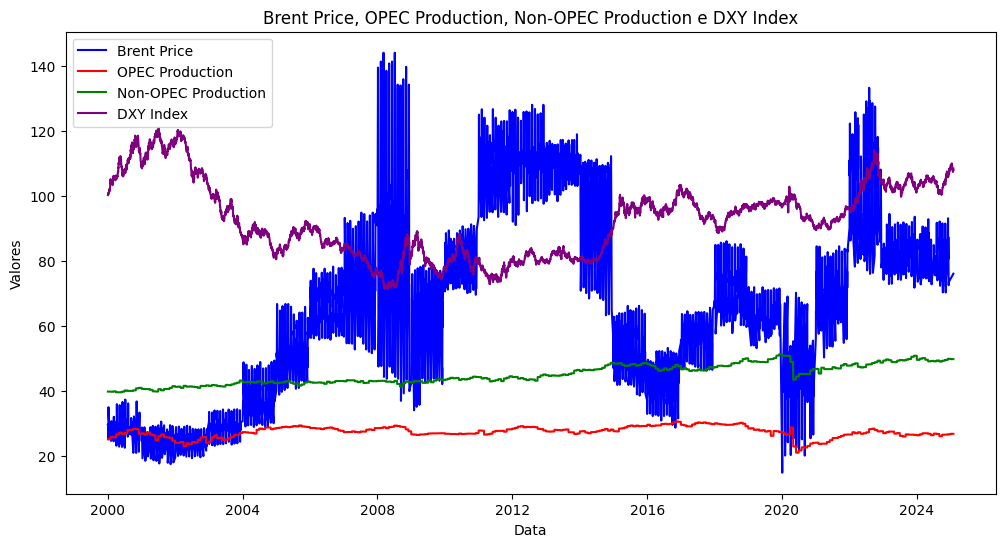

In [312]:
plt.figure(figsize=(12, 6))

# Plotar cada variável corretamente
sns.lineplot(data=df_merged, x=df_merged.index, y=df_merged["brent_price"], label="Brent Price", color="blue")
sns.lineplot(data=df_merged, x=df_merged.index, y=df_merged["production_value_opec"], label="OPEC Production", color="red")
sns.lineplot(data=df_merged, x=df_merged.index, y=df_merged["production_value_no_opec"], label="Non-OPEC Production", color="green")
sns.lineplot(data=df_merged, x=df_merged.index, y=df_merged["dxy_value_close"], label="DXY Index", color="purple")

plt.xlabel("Data")
plt.ylabel("Valores")
plt.title("Brent Price, OPEC Production, Non-OPEC Production e DXY Index")
plt.legend()
plt.show()


### Calculando a correlação entre os dados: Brent, Produção de petróleo da OPEP e não OPEP e DXY

In [313]:
df_corr = df_merged.corr()
df_corr

,brent_price,production_value_opec,production_value_no_opec,dxy_value_close
brent_price,1.000000,0.215550,0.343095,-0.557105
production_value_opec,0.215550,1.000000,0.204440,-0.289029
production_value_no_opec,0.343095,0.204440,1.000000,0.115529
dxy_value_close,-0.557105,-0.289029,0.115529,1.000000


### Heatmap da correlação entre os dados quantitativos:

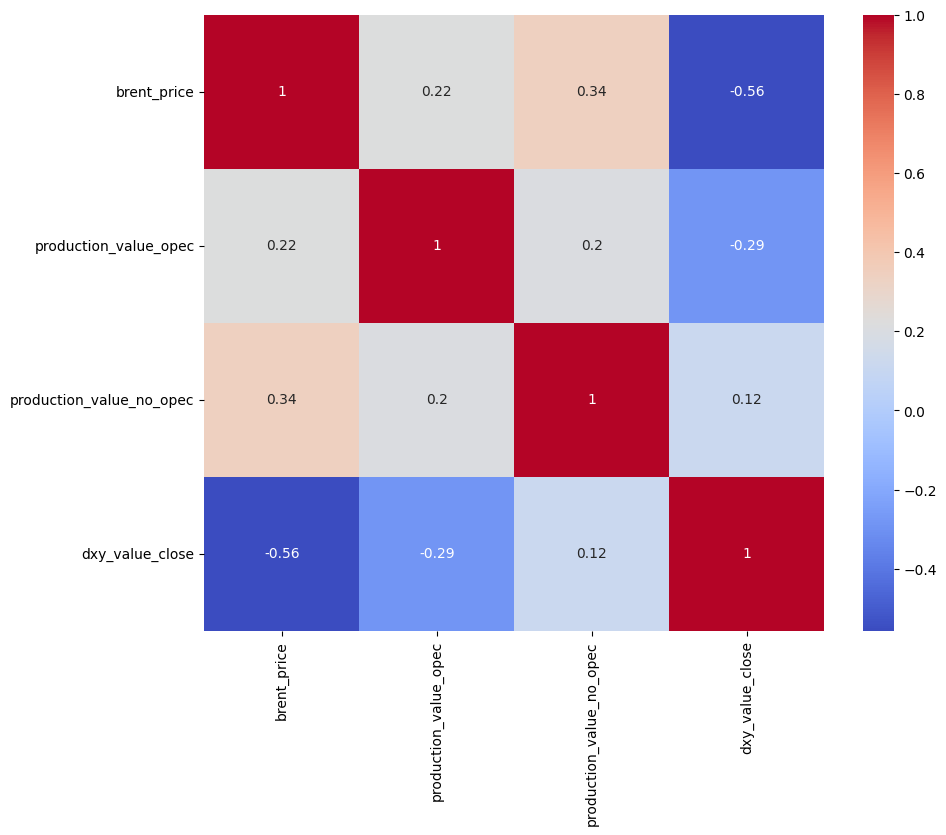

In [314]:
#plotando a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(df_merged.corr(), annot=True, cmap='coolwarm')

plt.show()


### Adicionando fatores qualitaivos considerados relevantes para o modelo de Machine Learning

In [315]:
# Criar colunas com 0 (sem evento) por padrão
df_merged['war_ukraine'] = 0


# Definir períodos dos eventos
df_merged.loc[df_merged.index >= '2022-02-24', 'war_ukraine'] = 1  # Guerra Ucrânia

# Conferir as novas colunas
print(df_merged['war_ukraine'].value_counts())


war_ukraine
0    8088
1    1073
Name: count, dtype: int64


### Matriz de correlação com os fatores qualitativos e quantitativos:

In [316]:
df_corr = df_merged.corr()
df_corr

,brent_price,production_value_opec,production_value_no_opec,dxy_value_close,war_ukraine
brent_price,1.000000,0.215550,0.343095,-0.557105,0.240714
production_value_opec,0.215550,1.000000,0.204440,-0.289029,-0.105406
production_value_no_opec,0.343095,0.204440,1.000000,0.115529,0.498178
dxy_value_close,-0.557105,-0.289029,0.115529,1.000000,0.378054
war_ukraine,0.240714,-0.105406,0.498178,0.378054,1.000000


### Heatmap da correlação entre os dados quantitativos e qualitativos:

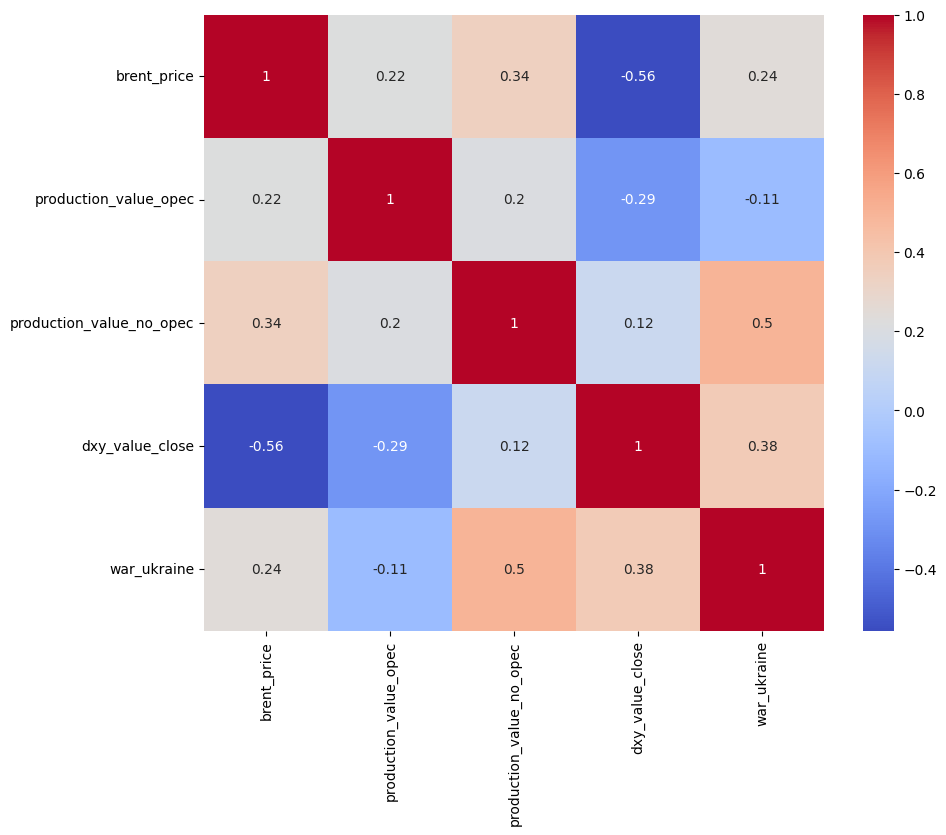

In [317]:
#nova matrix de correlação com dados da guerra da ucrânia e pandemia
plt.figure(figsize=(10, 8))
sns.heatmap(df_merged.corr(), annot=True, cmap='coolwarm')

plt.show()


In [318]:
#rodando o sarimax com os dados do df_merged faca todos imports necessarios
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar o modelo SARIMAX
model = SARIMAX(df_merged['brent_price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

#imprima as metricas para comparação com outros modelos 4 metricas
mae = mean_absolute_error(df_merged['brent_price'], results.fittedvalues)
mse = mean_squared_error(df_merged['brent_price'], results.fittedvalues)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((df_merged['brent_price'] - results.fittedvalues) / df_merged['brent_price'])) * 100

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

#salve as metricas em um arquivo txt
with open('data/processed/sarimax_metrics.txt', 'w') as f:
    f.write(f'MAE: {mae:.2f}\n')
    f.write(f'MSE: {mse:.2f}\n')
    f.write(f'RMSE: {rmse:.2f}\n')
    f.write(f'MAPE: {mape:.2f}%\n')


MAE: 2.14
MSE: 16.62
RMSE: 4.08
MAPE: 3.54%


### Treinando o modelo acrescentando lags e fatores externos para prever o preço do barril de petróleo Brent

In [324]:
for lag in [1, 2, 3, 5, 7, 14]:
    df_merged[f'lag_{lag}'] = df_merged['brent_price'].shift(lag)

df_merged['rolling_mean_7'] = df_merged['brent_price'].rolling(7).mean()
df_merged['pct_change_1'] = df_merged['brent_price'].pct_change(1)
df_merged['dxy_change'] = df_merged['dxy_value_close'].pct_change(1)
df_merged['is_weekend'] = df_merged.index.weekday >= 5

df_merged = df_merged.dropna()


features = [col for col in df_merged.columns if col != 'brent_price']
X = df_merged[features]
y = df_merged['brent_price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Definir modelo e hiperparâmetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Otimizar hiperparâmetros
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Melhor modelo
tuned_model = grid_search.best_estimator_

# Fazer previsões
y_pred = tuned_model.predict(X_test)

# Avaliar o modelo use 4 métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100




print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {mse:.2f}")
print(f"MAPE: {mape:.2f}%")

#salve as metricas em um arquivo txt
with open('data/processed/xgboost_metrics.txt', 'w') as f:
    f.write(f"MAE: {mae:.2f}\n")
    f.write(f"MSE: {mse:.2f}\n")
    f.write(f"RMSE: {rmse:.2f}\n")
    f.write(f"MAPE: {mape:.2f}%\n")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
MAE: 0.88
MSE: 2.84
RMSE: 2.84
MAPE: 1.45%


In [ ]:
#salvando os resultados do modelo em um arquivo csv
df_results = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_results.to_csv('data/processed/xgboost_results.csv')

#plotando o grafico de previsão
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred, label='Previsto')
plt.title('Preço do Brent - Real vs Previsto')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)


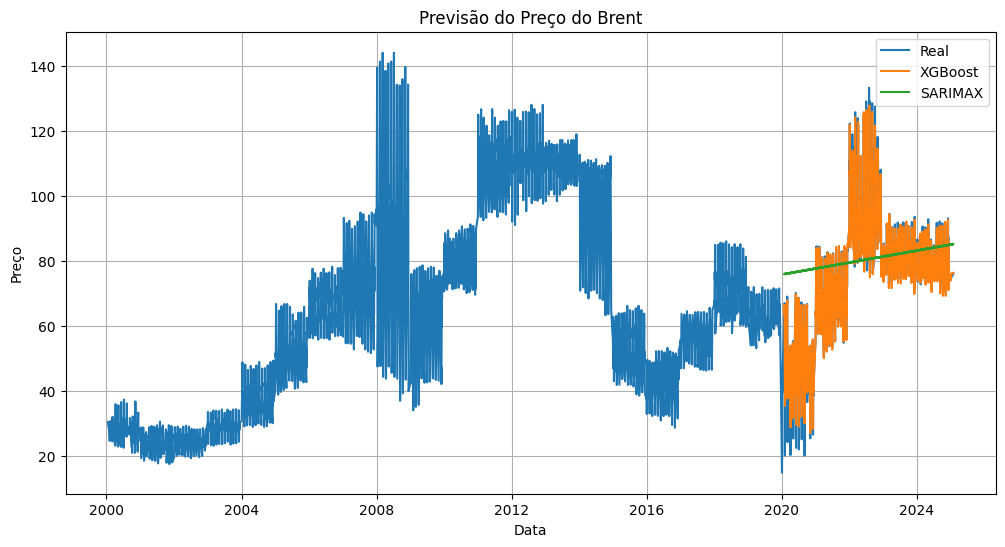

In [320]:
#plotando o grafico de previsão dos dois modelos saximax e xgboost
plt.figure(figsize=(12, 6))
plt.plot(df_merged.index, df_merged['brent_price'], label='Real')
plt.plot(y_test.index, y_pred, label='XGBoost')
plt.plot(y_test.index, results.forecast(len(y_test)), label='SARIMAX')
plt.title('Previsão do Preço do Brent')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.show()


In [321]:
# Criando o DataFrame de comparação
df_comparacao = pd.DataFrame({
    'Data': pd.date_range(start='2025-01-22', periods=len(y_test), freq='D'),
    'Preço Real': y_test.values,
    'Previsão XGBoost': y_pred
})

# Exibir a tabela
print(df_comparacao)


           Data  Preço Real  Previsão XGBoost
0    2025-01-22   64.047000         63.696480
1    2025-01-23   65.048000         63.974159
2    2025-01-24   66.049000         65.502769
3    2025-01-25   67.050000         66.554619
4    2025-01-26   59.785000         59.440395
...         ...         ...               ...
1825 2030-01-21   75.883137         76.324692
1826 2030-01-22   75.934510         76.331741
1827 2030-01-23   75.985882         76.331741
1828 2030-01-24   76.037255         76.339470
1829 2030-01-25   76.088627         76.331741

[1830 rows x 3 columns]


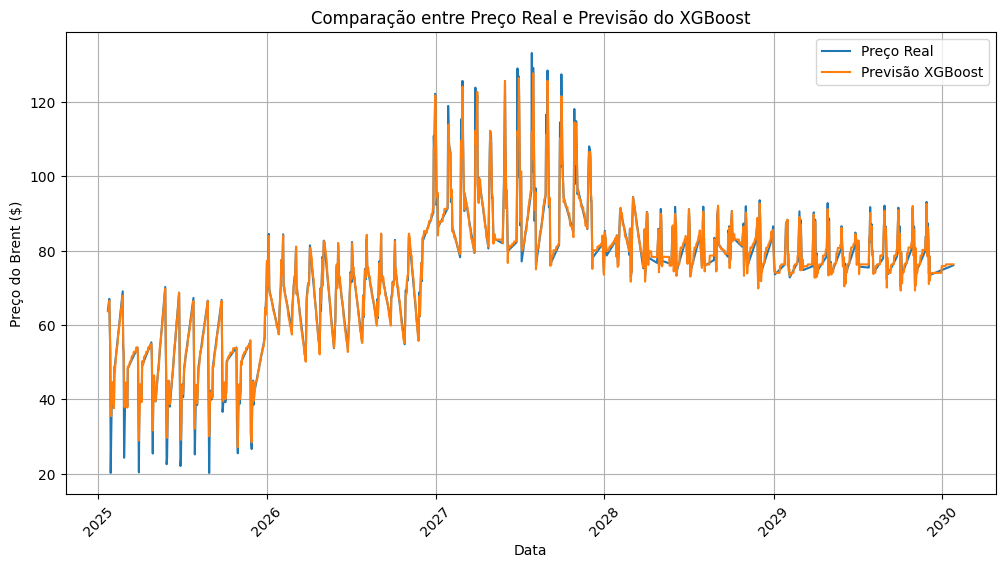

In [322]:
# Criando o gráfico comparativo
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_comparacao['Data'], y=df_comparacao['Preço Real'], label='Preço Real')
sns.lineplot(x=df_comparacao['Data'], y=df_comparacao['Previsão XGBoost'], label='Previsão XGBoost')

plt.xlabel('Data')
plt.ylabel('Preço do Brent ($)')
plt.title('Comparação entre Preço Real e Previsão do XGBoost')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Exibir o gráfico
plt.show()


In [323]:
# Salvar o modelo otimizado
tuned_model.save_model("modelo_brent.json")
print("Modelo otimizado salvo com sucesso!")


Modelo otimizado salvo com sucesso!
